In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning / TS
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Sklearn models & plumbing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    GradientBoostingClassifier, AdaBoostClassifier,
    HistGradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    roc_auc_score,
    precision_score, recall_score, f1_score, accuracy_score
)

warnings.filterwarnings("ignore")
RANDOM_STATE = 42

C:\Users\Katuz\anaconda3\envs\AI\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
forecast_files = range(1, 7)
daily_peaks = None

for n in forecast_files:
    file_path = f"IESO-Ontario Demand 2022-2025 {n} day ahead.csv"
    df_temp = pd.read_csv(file_path)
    # Remove unnamed columns that may appear in the CSV
    df_temp = df_temp.loc[:, ~df_temp.columns.str.contains('^Unnamed')]
    # Create datetime and date columns
    df_temp['datetime'] = pd.to_datetime(df_temp['Date'] + ' ' + df_temp['Time'], dayfirst=True, errors='coerce')
    df_temp['date'] = df_temp['datetime'].dt.date
    # Aggregate to find daily maximum (peak) values for each predictor and the actual load
    agg = df_temp.groupby('date').agg({
        'ECA: IESO-Ontario Demand Historic Forecast': 'max',
        'RTO: IESO-Ontario Demand Historic Forecast': 'max',
        'TESLA: IESO-Ontario Demand Historic Forecast': 'max',
        'TESLA: IESO-Ontario Demand Actual': 'max'
    }).reset_index()

    # Rename prediction columns to reflect the forecast horizon. The actual peak is kept only for the 1‑day horizon.
    rename_map = {
        'ECA: IESO-Ontario Demand Historic Forecast': f'ECA_peak_{n}d',
        'RTO: IESO-Ontario Demand Historic Forecast': f'RTO_peak_{n}d',
        'TESLA: IESO-Ontario Demand Historic Forecast': f'TESLA_pred_peak_{n}d'
    }
    agg = agg.rename(columns=rename_map)
    if n == 1:
        agg = agg.rename(columns={'TESLA: IESO-Ontario Demand Actual': 'actual_peak'})
    else:
        # Drop the actual column for horizons other than 1 day ahead
        agg = agg.drop(columns=['TESLA: IESO-Ontario Demand Actual'])
    # Merge the current horizon's daily peaks into the master DataFrame
    if daily_peaks is None:
        daily_peaks = agg
    else:
        daily_peaks = pd.merge(daily_peaks, agg, on='date', how='outer')

# Build timestamp and calendar fields
daily_peaks = daily_peaks.sort_values('date').reset_index(drop=True)
daily_peaks['timestamp'] = pd.to_datetime(daily_peaks['date'])
daily_peaks = daily_peaks.drop(columns=['date'])
daily_peaks['year'] = daily_peaks['timestamp'].dt.year
daily_peaks['month'] = daily_peaks['timestamp'].dt.month
daily_peaks['day'] = daily_peaks['timestamp'].dt.day

# Drop rows with missing Actual (do NOT ffill/bfill targets)
daily_peaks = daily_peaks.dropna(subset=['actual_peak']).reset_index(drop=True)

daily_peaks.head()

,ECA_peak_1d,RTO_peak_1d,TESLA_pred_peak_1d,actual_peak,ECA_peak_2d,RTO_peak_2d,TESLA_pred_peak_2d,ECA_peak_3d,RTO_peak_3d,TESLA_pred_peak_3d,...,ECA_peak_5d,RTO_peak_5d,TESLA_pred_peak_5d,ECA_peak_6d,RTO_peak_6d,TESLA_pred_peak_6d,timestamp,year,month,day
0,17310.5,17025.45,17025.45,16954.95,17475.6,17043.95,17043.95,17463.6,17010.40,17010.40,...,17463.6,17010.40,17010.40,17840.9,17581.75,17581.75,2022-01-01,2022,1,1
1,18871.0,19026.75,19026.75,18923.03,18786.2,18964.95,18964.95,18799.3,18996.50,18996.50,...,19558.7,19031.80,19031.80,19456.6,19394.10,19394.10,2022-01-02,2022,1,2
2,20130.1,20323.15,20323.15,20051.29,19924.1,20147.70,20147.70,19919.8,20304.15,20304.15,...,18846.3,19064.90,19064.90,18811.4,19031.55,19031.55,2022-01-03,2022,1,3
3,19548.8,19115.85,19115.85,19408.90,19387.7,19085.10,19085.10,19354.1,18939.90,18939.90,...,16516.5,16749.45,16749.45,16364.1,16493.05,16493.05,2022-01-04,2022,1,4
4,19494.2,19147.90,19147.90,19338.73,19794.5,19100.40,19100.40,19751.8,19011.60,19011.60,...,14541.7,14614.20,14614.20,14533.9,14699.70,14699.70,2022-01-05,2022,1,5


In [3]:
daily_peaks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227 entries, 0 to 1226
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ECA_peak_1d         1227 non-null   float64       
 1   RTO_peak_1d         1227 non-null   float64       
 2   TESLA_pred_peak_1d  1227 non-null   float64       
 3   actual_peak         1227 non-null   float64       
 4   ECA_peak_2d         1227 non-null   float64       
 5   RTO_peak_2d         1227 non-null   float64       
 6   TESLA_pred_peak_2d  1227 non-null   float64       
 7   ECA_peak_3d         1227 non-null   float64       
 8   RTO_peak_3d         1227 non-null   float64       
 9   TESLA_pred_peak_3d  1227 non-null   float64       
 10  ECA_peak_4d         1227 non-null   float64       
 11  RTO_peak_4d         1227 non-null   float64       
 12  TESLA_pred_peak_4d  1227 non-null   float64       
 13  ECA_peak_5d         453 non-null    float64     

In [4]:
# Descriptive statistics
stats = daily_peaks[[
    'actual_peak',
    'ECA_peak_1d',
    'RTO_peak_1d',
    'TESLA_pred_peak_1d'
]].describe()
stats

,actual_peak,ECA_peak_1d,RTO_peak_1d,TESLA_pred_peak_1d
count,1227.000000,1227.000000,1227.000000,1227.000000
mean,18135.832820,17856.211410,18093.216341,18093.216341
std,1879.666501,1619.048755,1846.455093,1846.455093
min,13303.840000,13631.700000,13696.100000,13696.100000
25%,16565.895000,16568.250000,16603.775000,16603.775000
50%,18139.780000,17909.000000,18103.450000,18103.450000
75%,19545.150000,19257.800000,19438.875000,19438.875000
max,23851.820000,21132.100000,24339.550000,24339.550000


In [5]:
# Check for missing values
missing = daily_peaks.isna().sum()
missing

ECA_peak_1d             0
RTO_peak_1d             0
TESLA_pred_peak_1d      0
actual_peak             0
ECA_peak_2d             0
RTO_peak_2d             0
TESLA_pred_peak_2d      0
ECA_peak_3d             0
RTO_peak_3d             0
TESLA_pred_peak_3d      0
ECA_peak_4d             0
RTO_peak_4d             0
TESLA_pred_peak_4d      0
ECA_peak_5d           774
RTO_peak_5d           774
TESLA_pred_peak_5d    774
ECA_peak_6d           774
RTO_peak_6d           774
TESLA_pred_peak_6d    774
timestamp               0
year                    0
month                   0
day                     0
dtype: int64

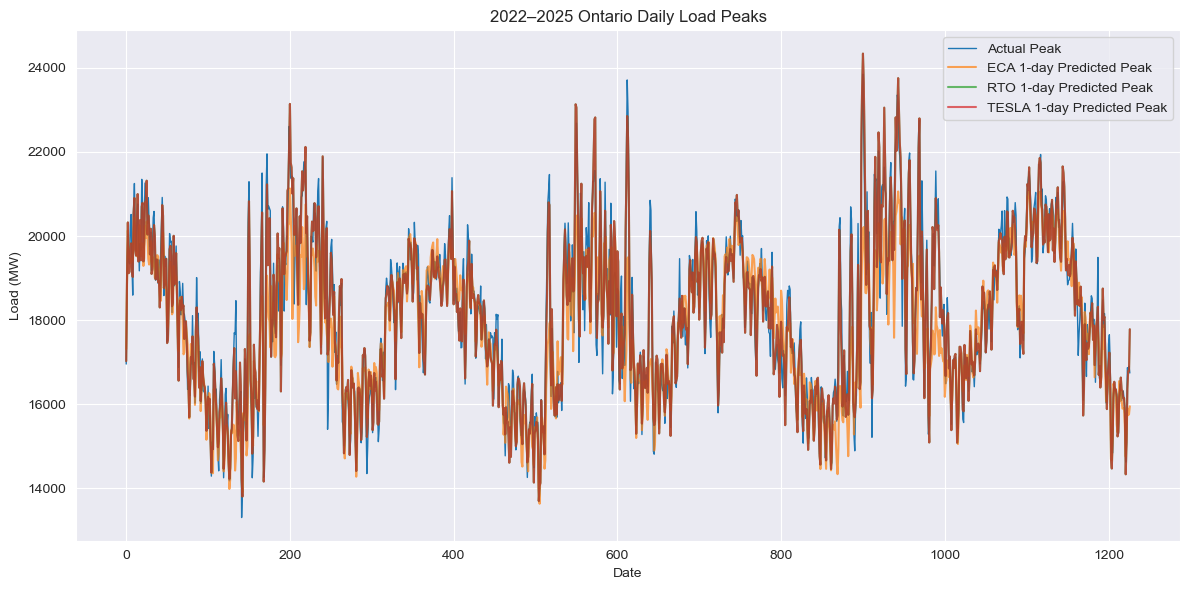

In [6]:
# Draw the trends of actual peaks and predicted peaks in chronological order
plt.figure(figsize=(12, 6))
plt.plot(daily_peaks.index, daily_peaks['actual_peak'], label='Actual Peak', linewidth=1.0)
plt.plot(daily_peaks.index, daily_peaks['ECA_peak_1d'], label='ECA 1-day Predicted Peak', alpha=0.7)
plt.plot(daily_peaks.index, daily_peaks['RTO_peak_1d'], label='RTO 1-day Predicted Peak', alpha=0.7)
plt.plot(daily_peaks.index, daily_peaks['TESLA_pred_peak_1d'], label='TESLA 1-day Predicted Peak', alpha=0.7)
plt.title('2022–2025 Ontario Daily Load Peaks')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.tight_layout()
plt.show()

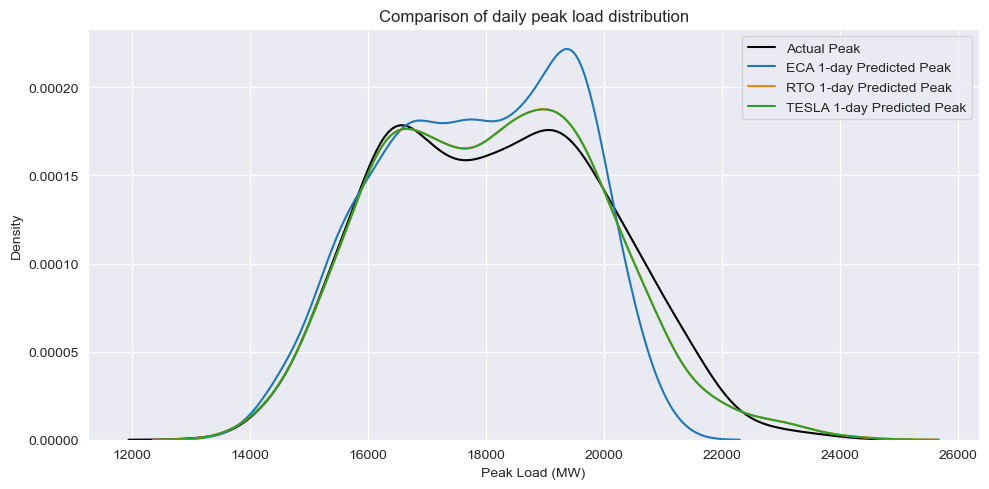

In [7]:
# Draw the distribution curve between the actual peak and the predicted peak
plt.figure(figsize=(10, 5))
for col, color, label in zip(['actual_peak', 'ECA_peak_1d', 'RTO_peak_1d', 'TESLA_pred_peak_1d'],
                             ['black', 'tab:blue', 'tab:orange', 'tab:green'],
                             ['Actual Peak', 'ECA 1-day Predicted Peak', 'RTO 1-day Predicted Peak',
                              'TESLA 1-day Predicted Peak']):
    # Use KDE curves to display the distribution, do not enable fill to avoid dtype problems
    sns.kdeplot(daily_peaks[col], label=label, color=color, linewidth=1.5)
plt.title('Comparison of daily peak load distribution')
plt.xlabel('Peak Load (MW)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

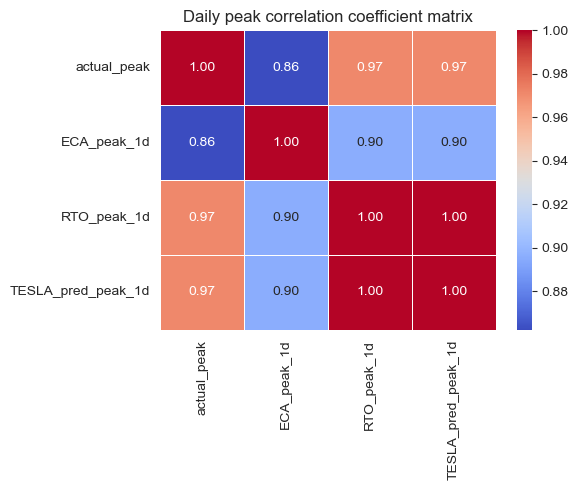

In [8]:
# Calculate the correlation coefficient matrix and draw the heat map
corr = daily_peaks[['actual_peak', 'ECA_peak_1d', 'RTO_peak_1d', 'TESLA_pred_peak_1d']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Daily peak correlation coefficient matrix')
plt.tight_layout()
plt.show()

In [9]:
# Label Monthly 4CP (Jun–Sep) — top 4 days by actual_peak *per month*
daily_peaks['is_CP'] = 0
summer_mask = daily_peaks['month'].between(6, 9)
for (y, m), sub in daily_peaks[summer_mask].groupby(['year', 'month']):
    if len(sub) < 20:  # skip partial months
        continue
    top_idx = sub.nlargest(4, 'actual_peak').index
    daily_peaks.loc[top_idx, 'is_CP'] = 1

daily_peaks[daily_peaks['is_CP'] == 1][['timestamp', 'actual_peak', 'year', 'month']].sort_values(
    ['year', 'month', 'actual_peak'], ascending=[True, True, False])

,timestamp,actual_peak,year,month
172,2022-06-22,21953.98,2022,6
166,2022-06-16,21499.52,2022,6
171,2022-06-21,21203.92,2022,6
174,2022-06-24,20714.83,2022,6
199,2022-07-19,22607.37,2022,7
200,2022-07-20,21850.29,2022,7
203,2022-07-23,21422.94,2022,7
201,2022-07-21,21378.51,2022,7
240,2022-08-29,21870.74,2022,8
218,2022-08-07,21778.08,2022,8


In [10]:
# Features and Split (ALL months). TS wrappers align to X; no scalers anywhere.
def pick_main_feature(cols):
    for cand in ['ECA_peak_1d', 'RTO_peak_1d', 'TESLA_pred_peak_1d']:
        if cand in cols:
            return cand
    return cols[0]


forecast_files = range(1, 7)
selected_feature = 'ECA'  # 'ECA' or 'RTO', 'TESLA', or 'ALL'
feature_cols = []
if selected_feature == 'ECA':
    feature_cols = [f'ECA_peak_{n}d' for n in forecast_files]
elif selected_feature == 'RTO':
    feature_cols = [f'RTO_peak_{n}d' for n in forecast_files]
elif selected_feature == 'TESLA':
    feature_cols = [f'TESLA_pred_peak_{n}d' for n in forecast_files]
else:
    for base in ['ECA_peak', 'RTO_peak', 'TESLA_pred_peak']:
        for n in forecast_files:
            feature_cols.append(f'{base}_{n}d')

MAIN_FEAT = pick_main_feature(feature_cols)

model_df = daily_peaks[['timestamp', 'year', 'month', 'actual_peak', 'is_CP'] + feature_cols].copy()

# Split: ALL months — 2022–2023 train; 2024–2025 test
separation = 2024
train_df = model_df[model_df['year'] < separation].copy()
test_df = model_df[model_df['year'] >= separation].copy()

X_train = train_df[feature_cols]
y_train = train_df['is_CP'].astype(int).values
X_test = test_df[feature_cols]
y_test = test_df['is_CP'].astype(int).values

In [11]:
USE_TOP_PCT_TRAIN = True  # True Enable "up to 10% of samples as training set"; False maintains the original training set
TOP_PCT = 0.10  # 10%
TOP_BY = 'actual_peak'
TOP_SCOPE = 'overall'

if USE_TOP_PCT_TRAIN:
    # 1) Select the range to calculate the threshold
    scope_df = model_df if TOP_SCOPE == 'overall' else train_df
    # 2) Calculate the quantile threshold and take Top‑K%
    thr = scope_df[TOP_BY].quantile(1.0 - TOP_PCT)
    scope_top_idx = scope_df.index[scope_df[TOP_BY] >= thr]

    if TOP_SCOPE == 'overall':
        train_top_df = model_df.loc[scope_top_idx].copy()
    else:
        train_top_df = train_df.loc[train_df.index.intersection(scope_top_idx)].copy()

    train_top_df = train_top_df.sort_values('timestamp').reset_index(drop=True)

    X_train = train_top_df[feature_cols]
    y_train = train_top_df['is_CP'].astype(int).values

    print(f"[INFO] Use top {int(TOP_PCT * 100)}% by '{TOP_BY}' for training "
          f"from scope='{TOP_SCOPE}': {len(y_train)} rows (sorted by timestamp).")
else:
    print("[INFO] Use original training split without top-percent filtering.")

[INFO] Use top 10% by 'actual_peak' for training from scope='overall': 123 rows (sorted by timestamp).


In [12]:
def compute_fill_values(df):
    arr = df.replace([np.inf, -np.inf], np.nan)
    return arr.median(numeric_only=True)


def impute_like_train(df, fill_values):
    arr = df.replace([np.inf, -np.inf], np.nan)
    arr = arr.ffill().bfill()
    for c, mv in fill_values.items():
        if c in arr.columns:
            arr[c] = arr[c].fillna(float(mv))
    return arr.fillna(0.0)


def sanitize_scores(s, base=0.5):
    s = np.asarray(s, dtype=float)
    s = np.nan_to_num(s, nan=base, posinf=1.0, neginf=0.0)
    return np.clip(s, 0.0, 1.0)


# --- TS wrappers fixed to align on X (no resizing hacks, no scalers) ---
class ARIMAClassifier:
    def __init__(self, order=(2, 1, 2)):
        self.order = order
        self.model_ = None
        self.endog_name = None
        self.exog_names = []
        self.fill_values_ = None  # to store fill values for imputing

    def fit(self, X, y):
        df = X.copy()
        if df.shape[1] == 0 or len(df) < 10:
            self.model_ = None
            return self

        self.endog_name = df.columns[0]
        self.exog_names = list(df.columns[1:])

        self.fill_values_ = compute_fill_values(df)

        df = impute_like_train(df, self.fill_values_)
        endog = df[self.endog_name].astype(float)
        exog = df[self.exog_names].astype(float) if len(self.exog_names) > 0 else None

        try:
            self.model_ = SARIMAX(endog, exog=exog, order=self.order,
                                  enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        except Exception:
            self.model_ = None
        return self

    def predict_proba(self, X):
        n = len(X)
        if self.model_ is None or n == 0:
            probs = np.full(n, 0.5, dtype=float)
            probs = sanitize_scores(probs)
            return np.column_stack([1 - probs, probs])

        # Take exogenous variables in order of training
        df = X.copy()
        fill_vals = self.fill_values_ if self.fill_values_ is not None else compute_fill_values(df)
        df_imp = impute_like_train(df, fill_vals)
        exog_new = df_imp[self.exog_names].astype(float) if len(self.exog_names) > 0 else None

        try:
            forecast = self.model_.get_forecast(steps=n, exog=exog_new).predicted_mean
            z = (forecast - forecast.min()) / (forecast.max() - forecast.min() + 1e-12)
            probs = sanitize_scores(z.values if hasattr(z, "values") else z)
        except Exception:
            probs = np.full(n, 0.5, dtype=float)
            probs = sanitize_scores(probs)

        return np.column_stack([1 - probs, probs])


class LSTMClassifier:
    def __init__(self, seq_length=30, lstm_units=64):
        self.seq_length = seq_length
        self.lstm_units = lstm_units
        self.model = None
        self.feature_names = None  # Keep the order of columns during training
        self.fill_values_ = None

    def _make_sequences(self, X_2d):
        A = np.asarray(X_2d, dtype=float)
        n, f = A.shape
        L = self.seq_length
        if n <= L:
            return np.empty((0, L, f), dtype=float), np.array([], dtype=int)
        Xs = np.stack([A[i:i + L] for i in range(n - L)], axis=0)
        idx = np.arange(L, n, dtype=int)
        return Xs, idx

    def fit(self, X, y):
        # Record and lock the sequence of feature columns
        self.feature_names = list(X.columns)
        self.fill_values_ = compute_fill_values(X[self.feature_names])
        X_imp = impute_like_train(X[self.feature_names], self.fill_values_)
        A = X_imp.values

        Xs, idx = self._make_sequences(A)
        if len(Xs) == 0:
            self.model = None
            return self
        y_arr = np.asarray(y, dtype=float)[idx]

        self.model = Sequential([
            Input(shape=(self.seq_length, A.shape[1])),
            LSTM(self.lstm_units, return_sequences=True),
            Dropout(0.2),
            LSTM(self.lstm_units // 2),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

        try:
            self.model.fit(Xs, y_arr, epochs=30, batch_size=32, verbose=0,
                           callbacks=[EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)])
        except Exception:
            self.model = None
        return self

    def predict_proba(self, X):
        n = len(X)
        if self.model is None or n == 0:
            probs = np.full(n, 0.5, dtype=float)
            probs = sanitize_scores(probs)
            return np.column_stack([1 - probs, probs])

        # Features are selected in the order of columns during training
        Xp = X[self.feature_names].copy()
        fill_vals = self.fill_values_ if self.fill_values_ is not None else compute_fill_values(Xp)
        X_imp = impute_like_train(Xp, fill_vals)
        A = X_imp.values

        Xs, idx = self._make_sequences(A)
        if len(Xs) == 0:
            probs = np.full(n, 0.5, dtype=float)
        else:
            p = self.model.predict(Xs, verbose=0).flatten()
            base = float(np.nanmin(p)) if len(p) > 0 else 0.5
            probs = np.full(n, base, dtype=float)
            probs[idx] = p

        probs = sanitize_scores(probs)
        return np.column_stack([1 - probs, probs])


class GRUClassifier:
    def __init__(self, seq_length=30, gru_units=64):
        self.seq_length = seq_length
        self.gru_units = gru_units
        self.model = None
        self.feature_names = None
        self.fill_values_ = None

    def _make_sequences(self, X_2d):
        A = np.asarray(X_2d, dtype=float)
        n, f = A.shape
        L = self.seq_length
        if n <= L:
            return np.empty((0, L, f), dtype=float), np.array([], dtype=int)
        Xs = np.stack([A[i:i + L] for i in range(n - L)], axis=0)
        idx = np.arange(L, n, dtype=int)
        return Xs, idx

    def fit(self, X, y):
        self.feature_names = list(X.columns)
        self.fill_values_ = compute_fill_values(X[self.feature_names])
        X_imp = impute_like_train(X[self.feature_names], self.fill_values_)
        A = X_imp.values

        Xs, idx = self._make_sequences(A)
        if len(Xs) == 0:
            self.model = None
            return self
        y_arr = np.asarray(y, dtype=float)[idx]

        self.model = Sequential([
            Input(shape=(self.seq_length, A.shape[1])),
            GRU(self.gru_units, return_sequences=True),
            Dropout(0.2),
            GRU(self.gru_units // 2),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

        try:
            self.model.fit(Xs, y_arr, epochs=30, batch_size=32, verbose=0,
                           callbacks=[EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)])
        except Exception:
            self.model = None
        return self

    def predict_proba(self, X):
        n = len(X)
        if self.model is None or n == 0:
            probs = np.full(n, 0.5, dtype=float)
            probs = sanitize_scores(probs)
            return np.column_stack([1 - probs, probs])

        Xp = X[self.feature_names].copy()
        fill_vals = self.fill_values_ if self.fill_values_ is not None else compute_fill_values(Xp)
        X_imp = impute_like_train(Xp, fill_vals)
        A = X_imp.values

        Xs, idx = self._make_sequences(A)
        if len(Xs) == 0:
            probs = np.full(n, 0.5, dtype=float)
        else:
            p = self.model.predict(Xs, verbose=0).flatten()
            base = float(np.nanmin(p)) if len(p) > 0 else 0.5
            probs = np.full(n, base, dtype=float)
            probs[idx] = p

        probs = sanitize_scores(probs)
        return np.column_stack([1 - probs, probs])

In [13]:
models = {
    "Logistic Regression": Pipeline([('imp', SimpleImputer(strategy='median')),
                                     ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))]),
    "Decision Tree": Pipeline([('imp', SimpleImputer(strategy='median')),
                               ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))]),
    "Random Forest": Pipeline([('imp', SimpleImputer(strategy='median')),
                               ('clf',
                                RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1))]),
    "Extra Trees": Pipeline([('imp', SimpleImputer(strategy='median')),
                             ('clf', ExtraTreesClassifier(n_estimators=800, random_state=RANDOM_STATE, n_jobs=-1))]),
    "Gradient Boosting": Pipeline([('imp', SimpleImputer(strategy='median')),
                                   ('clf', GradientBoostingClassifier(random_state=RANDOM_STATE))]),
    "AdaBoost": Pipeline([('imp', SimpleImputer(strategy='median')),
                          ('clf', AdaBoostClassifier(random_state=RANDOM_STATE))]),
    "Hist Gradient Boosting": Pipeline([('imp', SimpleImputer(strategy='median')),
                                        ('clf', HistGradientBoostingClassifier(random_state=RANDOM_STATE))]),
    "KNN": Pipeline([('imp', SimpleImputer(strategy='median')),
                     ('clf', KNeighborsClassifier(n_neighbors=5))]),
    "SVM (Linear)": Pipeline([('imp', SimpleImputer(strategy='median')),
                              ('clf', SVC(kernel='linear', probability=True, random_state=RANDOM_STATE))]),
    "SVM (RBF)": Pipeline([('imp', SimpleImputer(strategy='median')),
                           ('clf', SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE))]),
    "GaussianNB": Pipeline([('imp', SimpleImputer(strategy='median')),
                            ('clf', GaussianNB())]),
    "LDA": Pipeline([('imp', SimpleImputer(strategy='median')),
                     ('clf', LinearDiscriminantAnalysis())]),
    "QDA": Pipeline([('imp', SimpleImputer(strategy='median')),
                     ('clf', QuadraticDiscriminantAnalysis(reg_param=0.1))]),
    "MLP": Pipeline([('imp', SimpleImputer(strategy='median')),
                     ('clf', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=RANDOM_STATE))]),
    # TS wrappers (no pipeline; they handle raw features internally)
    "ARIMA": ARIMAClassifier(order=(2, 1, 2)),
    "LSTM": LSTMClassifier(seq_length=30, lstm_units=64),
    "GRU": GRUClassifier(seq_length=30, gru_units=64),
}

results = []
proba_dict = {}

In [14]:
THRESH_PCTL = 0.95  # percentile threshold for determining high-load (CP) days
THRESH_FACTOR = 4  # weight multiplier applied to high-load days


def wei_classification(y_true, prob, threshold_percentile=THRESH_PCTL, weight_factor=THRESH_FACTOR):
    y_true_array = np.asarray(y_true).astype(float)
    prob = np.asarray(prob).astype(float)
    # quantile on labels (binary -> typically 1.0 if any positives)
    threshold = np.quantile(y_true_array, threshold_percentile)
    weights = np.where(y_true_array >= threshold, weight_factor, 1.0)
    weighted_error = np.abs(prob - y_true_array)
    total_w = weights.sum() + 1e-12
    wei = (weights * weighted_error).sum() / total_w
    tot_err = (weights * weighted_error).sum()
    if tot_err > 0:
        share = (weights[y_true_array >= threshold] * weighted_error[y_true_array >= threshold]).sum() / tot_err
    else:
        share = 0.0
    # return both the index and the share attributable to the high-weight class
    return float(wei), float(share)

In [15]:
# Train all models and compute probabilities on test
fitted_models = {}
prob_test = {}
for name, m in models.items():
    try:
        m.fit(X_train, y_train)
        fitted_models[name] = m
        if hasattr(m, "predict_proba"):
            s = m.predict_proba(X_test)[:, 1]
        else:
            # fall back to decision scores (should not happen for our set)
            s = m.decision_function(X_test)
            s = (s - s.min()) / (s.max() - s.min() + 1e-12)
        prob_test[name] = sanitize_scores(s)
    except Exception as e:
        print(f"[WARN] {name} failed during fit/predict: {e}")
        continue

# Overall trend metrics for 2024 only
test_2024 = test_df[test_df['year'] == 2024].copy()
X_2024 = test_2024[feature_cols]
y_2024 = test_2024['is_CP'].astype(int).values

overall_trend_2024 = {}

In [16]:
# Dynamic threshold search
fitted_models = {}
prob_test = {}
fit_failures = {}

for name, m in models.items():
    try:
        m.fit(X_train, y_train)
        fitted_models[name] = m
        if hasattr(m, "predict_proba"):
            s = m.predict_proba(X_test)[:, 1]
        else:
            s = m.decision_function(X_test)
            s = (s - s.min()) / (s.max() - s.min() + 1e-12)
        prob_test[name] = sanitize_scores(s)
    except Exception as e:
        fit_failures[name] = str(e)

print("[INFO] Fitted models:")
for k in models.keys():
    if k in fitted_models:
        print(f"  - {k}: OK")
    else:
        print(f"  - {k}: FAILED")

if fit_failures:
    print("[INFO] Failure reasons:")
    for k, v in fit_failures.items():
        print(f"  - {k}: {v}")

USE_ADAPTIVE_THRESHOLD = True
VAL_SCOPE = 'train'
EPS = 1e-12


def predict_proba_sanitized(model, X):
    if hasattr(model, "predict_proba"):
        s = model.predict_proba(X)[:, 1]
    else:
        s = model.decision_function(X)
        s = (s - s.min()) / (s.max() - s.min() + EPS)
    return sanitize_scores(s)


# validation split for threshold search
if VAL_SCOPE == 'train':
    X_val = train_df[feature_cols]
    y_val = train_df['is_CP'].astype(int).values
elif VAL_SCOPE == 'year=2023':
    val_df = model_df[model_df['year'] == 2023]
    X_val = val_df[feature_cols]
    y_val = val_df['is_CP'].astype(int).values
else:
    X_val = train_df[feature_cols]
    y_val = train_df['is_CP'].astype(int).values

thr_by_model = {}
val_pos_rate = float(y_val.mean())

for name, m in fitted_models.items():
    try:
        s_val = predict_proba_sanitized(m, X_val)
        if np.allclose(np.max(s_val), np.min(s_val)):
            # constant scores -> fallback to fraction-based quantile
            thr = np.quantile(s_val, 1.0 - val_pos_rate) if 0.0 < val_pos_rate < 1.0 else 0.5
        else:
            prec, rec, ths = precision_recall_curve(y_val, s_val)
            if len(ths) == 0:
                thr = 0.5
            else:
                f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + EPS)
                thr = float(ths[int(np.nanargmax(f1s))])
        thr_by_model[name] = thr
    except Exception as e:
        thr_by_model[name] = None

print("[INFO] Adaptive thresholds learned:")
for name in models.keys():
    v = thr_by_model.get(name, None)
    if v is None:
        print(f"  - {name}: N/A")
    else:
        print(f"  - {name}: {v:.6f}")


# helper: apply threshold with top-k fallback to avoid all-negative/all-positive
def apply_threshold_with_fallback(scores, base_thr, train_pos_rate):
    n = len(scores)
    y_pred = (scores >= base_thr).astype(int)
    if n == 0:
        return y_pred, base_thr
    # if all negative -> pick top-k by train positive rate
    if y_pred.sum() == 0 and train_pos_rate > 0:
        k = max(1, int(round(train_pos_rate * n)))
        if k >= n:
            return np.ones(n, dtype=int), float(np.min(scores))
        kth = np.partition(scores, n - k)[n - k]
        y_pred = (scores >= kth).astype(int)
        return y_pred, float(kth)
    # if all positive -> trim by (1 - train_pos_rate)
    if y_pred.sum() == n and train_pos_rate < 1:
        k0 = max(1, int(round((1 - train_pos_rate) * n)))
        kth = np.partition(scores, k0 - 1)[k0 - 1]
        y_pred = (scores > kth).astype(int)
        return y_pred, float(kth)
    return y_pred, base_thr


test_2024 = test_df[test_df['year'] == 2024].copy()
X_2024 = test_2024[feature_cols]
y_2024 = test_2024['is_CP'].astype(int).values

overall_trend_2024_adaptive = {}
for name, m in fitted_models.items():
    try:
        s24 = predict_proba_sanitized(m, X_2024)
        base_thr = thr_by_model.get(name, 0.5) if USE_ADAPTIVE_THRESHOLD else 0.5
        # robust fallback to avoid degenerate all-0/all-1 predictions
        y_pred, used_thr = apply_threshold_with_fallback(s24, base_thr, val_pos_rate)

        prec = precision_score(y_2024, y_pred, zero_division=0)
        rec = recall_score(y_2024, y_pred, zero_division=0)
        f1 = f1_score(y_2024, y_pred, zero_division=0)
        acc = accuracy_score(y_2024, y_pred)
        try:
            auc = roc_auc_score(y_2024, s24) if len(np.unique(y_2024)) > 1 else np.nan
        except Exception:
            auc = np.nan
        wei_val, wei_share = wei_classification(y_2024, s24)

        overall_trend_2024_adaptive[name] = dict(
            Precision=prec, Recall=rec, F1score=f1, Accuracy=acc, AUC=auc,
            WEI=wei_val, WEI_share=wei_share,
            thr=used_thr, pos_pred=int(y_pred.sum())
        )
    except Exception as e:
        overall_trend_2024_adaptive[name] = dict(
            Precision=np.nan, Recall=np.nan, F1score=np.nan, Accuracy=np.nan,
            AUC=np.nan, WEI=np.nan, WEI_share=np.nan, thr=np.nan, pos_pred=0,
            error=str(e)
        )

overall_trend_df_2024_adaptive = (
    pd.DataFrame.from_dict(overall_trend_2024_adaptive, orient='index')
    .rename_axis('model').reset_index()
)
print("Overall trend metrics on 2024 with adaptive thresholds (with fallback):")
display(overall_trend_df_2024_adaptive.sort_values(['AUC', 'F1score', 'Precision'], ascending=[False, False, False]))

[INFO] Fitted models:
  - Logistic Regression: OK
  - Decision Tree: OK
  - Random Forest: OK
  - Extra Trees: OK
  - Gradient Boosting: OK
  - AdaBoost: OK
  - Hist Gradient Boosting: OK
  - KNN: OK
  - SVM (Linear): OK
  - SVM (RBF): OK
  - GaussianNB: OK
  - LDA: OK
  - QDA: OK
  - MLP: OK
  - ARIMA: OK
  - LSTM: OK
  - GRU: OK
[INFO] Adaptive thresholds learned:
  - Logistic Regression: 0.575287
  - Decision Tree: 1.000000
  - Random Forest: 0.726667
  - Extra Trees: 1.000000
  - Gradient Boosting: 0.922109
  - AdaBoost: 0.535152
  - Hist Gradient Boosting: 0.738571
  - KNN: 0.800000
  - SVM (Linear): 0.617506
  - SVM (RBF): 0.622269
  - GaussianNB: 0.016266
  - LDA: 0.543015
  - QDA: 0.998122
  - MLP: 0.000000
  - ARIMA: 0.932986
  - LSTM: 0.262067
  - GRU: 0.305361
Overall trend metrics on 2024 with adaptive thresholds (with fallback):


,model,Precision,Recall,F1score,Accuracy,AUC,WEI,WEI_share,thr,pos_pred
3,Extra Trees,1.000000,0.8750,0.933333,0.994536,0.928036,0.335273,1.0,1.000000e+00,14
2,Random Forest,0.307692,0.7500,0.436364,0.915301,0.911339,0.350656,1.0,7.266667e-01,39
13,MLP,0.333333,0.2500,0.285714,0.945355,0.905000,0.043716,1.0,6.599239e-80,12
4,Gradient Boosting,0.222222,0.2500,0.235294,0.928962,0.865357,0.258963,1.0,9.221088e-01,18
5,AdaBoost,0.263158,0.3125,0.285714,0.931694,0.847768,0.461764,1.0,5.351518e-01,19
0,Logistic Regression,0.200000,0.2500,0.222222,0.923497,0.840179,0.223648,1.0,5.752871e-01,20
11,LDA,0.178571,0.3125,0.227273,0.907104,0.828929,0.216800,1.0,5.430149e-01,28
1,Decision Tree,0.106383,0.9375,0.191083,0.653005,0.788750,0.346995,1.0,1.000000e+00,141
6,Hist Gradient Boosting,0.600000,0.1875,0.285714,0.959016,0.752679,0.395590,1.0,7.385712e-01,5
7,KNN,0.230769,0.1875,0.206897,0.937158,0.740089,0.340984,1.0,8.000000e-01,13


In [17]:
for name, m in fitted_models.items():
    try:
        s24 = m.predict_proba(X_2024)[:, 1] if hasattr(m, "predict_proba") else m.decision_function(X_2024)
        s24 = sanitize_scores(s24)
        y_pred = (s24 >= 0.5).astype(int)
        precision = precision_score(y_2024, y_pred, zero_division=0)
        recall = recall_score(y_2024, y_pred, zero_division=0)
        f1 = f1_score(y_2024, y_pred, zero_division=0)
        accuracy = accuracy_score(y_2024, y_pred)
        auc_val = roc_auc_score(y_2024, s24) if len(np.unique(y_2024)) > 1 else np.nan
        wei_val, wei_share = wei_classification(y_2024, s24)
        overall_trend_2024[name] = {
            'Precision': precision,
            'Accuracy': accuracy,
            'Recall': recall,
            'AUC': auc_val,
            'F1score': f1,
            'WEI': wei_val,
            'WEI_share': wei_share
        }
    except Exception as e:
        overall_trend_2024[name] = {'Precision': np.nan, 'Accuracy': np.nan, 'Recall': np.nan, 'AUC': np.nan,
                                    'F1score': np.nan, 'WEI': np.nan, 'WEI_share': np.nan}
        print(f"[WARN] Trend metrics failed for {name}: {e}")

overall_trend_df_2024 = pd.DataFrame.from_dict(overall_trend_2024, orient='index').rename_axis('model').reset_index()
for col in ['Precision', 'Accuracy', 'Recall', 'AUC', 'F1score', 'WEI', 'WEI_share']:
    if col in overall_trend_df_2024.columns:
        overall_trend_df_2024[col] = overall_trend_df_2024[col].astype(float).round(4)

print("Overall trend metrics on 2024 (ALL months):")
display(overall_trend_df_2024.sort_values(['AUC', 'F1score', 'Precision'], ascending=[False, False, False]))

Overall trend metrics on 2024 (ALL months):


,model,Precision,Accuracy,Recall,AUC,F1score,WEI,WEI_share
3,Extra Trees,0.1085,0.6803,0.8750,0.9280,0.1931,0.3353,1.0
2,Random Forest,0.1293,0.7213,0.9375,0.9113,0.2273,0.3507,1.0
13,MLP,0.0000,0.9563,0.0000,0.9050,0.0000,0.0437,1.0
4,Gradient Boosting,0.1556,0.7869,0.8750,0.8654,0.2642,0.2590,1.0
5,AdaBoost,0.1057,0.6913,0.8125,0.8478,0.1871,0.4618,1.0
0,Logistic Regression,0.1471,0.8907,0.3125,0.8402,0.2000,0.2236,1.0
11,LDA,0.1471,0.8907,0.3125,0.8289,0.2000,0.2168,1.0
1,Decision Tree,0.1064,0.6530,0.9375,0.7887,0.1911,0.3470,1.0
6,Hist Gradient Boosting,0.0551,0.3825,0.8125,0.7527,0.1032,0.3956,1.0
7,KNN,0.0879,0.7514,0.5000,0.7401,0.1495,0.3410,1.0


In [18]:
# Monthly Precision@4 / Recall@4 for each model across the test period (Jun–Sep months)
def aggregated_p_r_at_4(df, scores):
    df = df.copy()
    df['score'] = scores
    total_hits = 0
    total_true = 0
    months = 0
    for (y, m), sub in df.groupby(['year', 'month']):
        if not (6 <= m <= 9):
            continue
        if len(sub) < 20:
            continue
        top4 = sub.nlargest(4, 'score')
        hits = int(top4['is_CP'].sum())
        denom = int(sub['is_CP'].sum())
        total_hits += hits
        total_true += denom
        months += 1
    precision4 = (total_hits / (4.0 * months)) if months > 0 else np.nan
    recall4 = (total_hits / total_true) if total_true > 0 else np.nan
    return precision4, recall4, months, total_true


rows = []
for name, s in prob_test.items():
    p4, r4, nmonths, tot_true = aggregated_p_r_at_4(test_df, s)
    rows.append({'Model': name, 'precision_at_4': p4, 'recall_at_4': r4})

p4r4_summary = pd.DataFrame(rows).sort_values('precision_at_4', ascending=False)
p4r4_summary['precision_at_4'] = p4r4_summary['precision_at_4'].round(4)
p4r4_summary['recall_at_4'] = p4r4_summary['recall_at_4'].round(4)

print("Aggregated Precision@4 / Recall@4 (single number per model):")
display(p4r4_summary[['Model', 'precision_at_4', 'recall_at_4']])

Aggregated Precision@4 / Recall@4 (single number per model):


,Model,precision_at_4,recall_at_4
3,Extra Trees,0.8750,0.8750
2,Random Forest,0.6250,0.6250
4,Gradient Boosting,0.5625,0.5625
14,ARIMA,0.4375,0.4375
0,Logistic Regression,0.3750,0.3750
7,KNN,0.3125,0.3125
13,MLP,0.3125,0.3125
11,LDA,0.3125,0.3125
5,AdaBoost,0.3125,0.3125
6,Hist Gradient Boosting,0.2500,0.2500


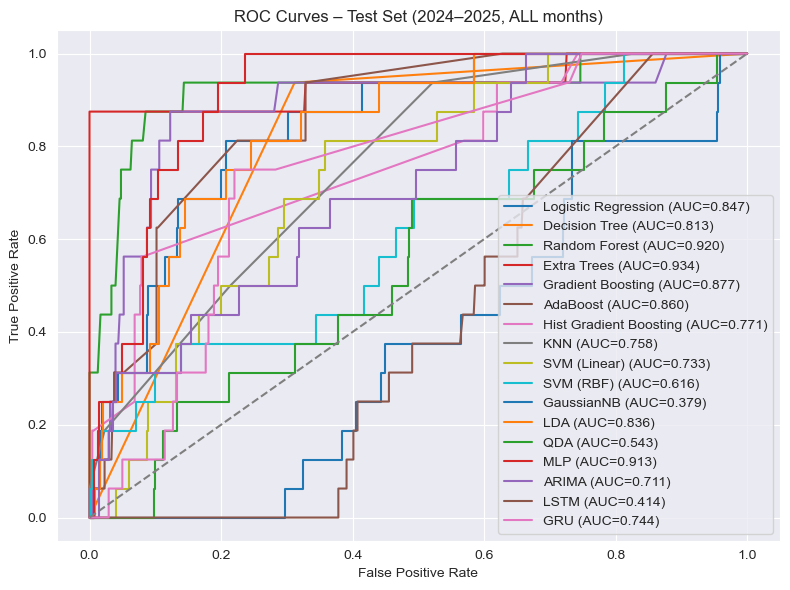

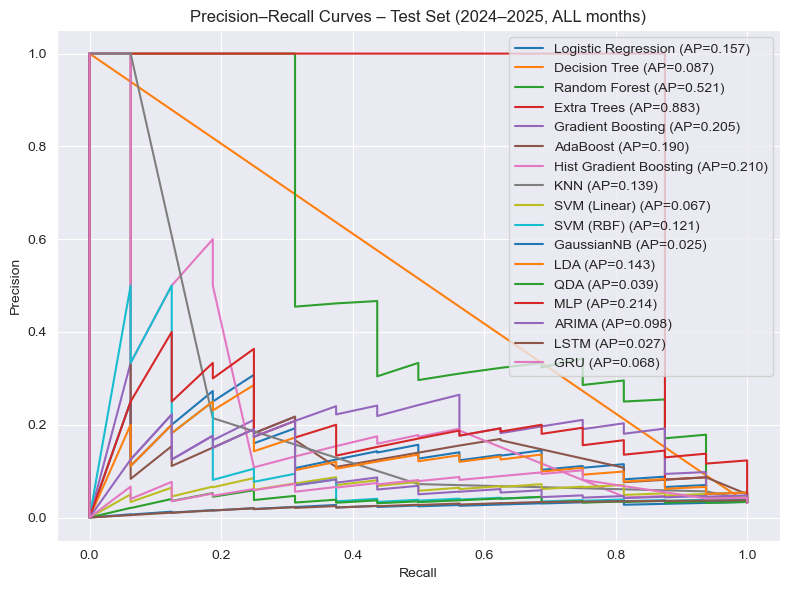

In [19]:
# ROC and Precision-Recall curves for 2024 (overall trend view)
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve as sk_roc_curve, auc as sk_auc

X_all = X_test
y_all = y_test

has_both_classes = (len(np.unique(y_all)) > 1)

# ROC
plt.figure(figsize=(8, 6))
plotted_any = False
if not has_both_classes:
    plt.text(0.5, 0.5, "ROC undefined for test set (single class in y).", ha='center', va='center')
else:
    for name, m in fitted_models.items():
        try:
            s = m.predict_proba(X_all)[:, 1] if hasattr(m, 'predict_proba') else m.decision_function(X_all)
            s = sanitize_scores(s)
            fpr, tpr, _ = sk_roc_curve(y_all, s)
            roc_auc_val = sk_auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_val:.3f})")
            plotted_any = True
        except Exception:
            continue
    plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves – Test Set (2024–2025, ALL months)')
if plotted_any:
    plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall
plt.figure(figsize=(8, 6))
plotted_any_pr = False
if y_all.sum() == 0:
    plt.text(0.5, 0.5, "PR undefined for test set (no positive class).", ha='center', va='center')
else:
    for name, m in fitted_models.items():
        try:
            s = m.predict_proba(X_all)[:, 1] if hasattr(m, 'predict_proba') else m.decision_function(X_all)
            s = sanitize_scores(s)
            precision, recall, _ = precision_recall_curve(y_all, s)
            ap_val = average_precision_score(y_all, s)
            plt.plot(recall, precision, label=f"{name} (AP={ap_val:.3f})")
            plotted_any_pr = True
        except Exception:
            continue

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves – Test Set (2024–2025, ALL months)')
if plotted_any_pr:
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [20]:
selected_model = "Extra Trees"  # change to any key in `models`
start_month, end_month = 6, 9

period_mask = (test_df['month'] >= start_month) & (test_df['month'] <= end_month)
period_data = test_df.loc[period_mask].copy()

if selected_model in fitted_models and not period_data.empty:
    mdl = fitted_models[selected_model]
    if hasattr(mdl, "predict_proba"):
        p = mdl.predict_proba(period_data[feature_cols])[:, 1]
    else:
        s = mdl.decision_function(period_data[feature_cols])
        p = (s - s.min()) / (s.max() - s.min() + 1e-12)
    period_data[f"{selected_model}_prob"] = p

    for year in sorted(period_data['year'].unique()):
        year_data = period_data[period_data['year'] == year]
        print(f"\n=== {year} results — {selected_model} ===")
        for month in sorted(year_data['month'].unique()):
            month_data = year_data[year_data['month'] == month]
            if len(month_data) < 1:
                continue
            sub = month_data[[f"{selected_model}_prob", "actual_peak", "is_CP", "timestamp"]].sort_values(
                f"{selected_model}_prob", ascending=False).head(4)
            display(sub)
            hits = int(sub['is_CP'].sum())
            total_cp_days = int(month_data['is_CP'].sum())
            precision4 = hits / 4.0
            print(f"Hits: {hits}/4 | True CP in month: {total_cp_days} | Precision@4: {precision4:.2%}")
            if total_cp_days > 0:
                recall4 = hits / total_cp_days
                print(f"Recall@4: {recall4:.2%}")
else:
    print("No data available for the selected model or period.")


=== 2024 results — Extra Trees ===


,Extra Trees_prob,actual_peak,is_CP,timestamp
898,1.0,21647.62,1,2024-06-17
899,1.0,23097.18,1,2024-06-18
900,1.0,23851.82,1,2024-06-19
901,1.0,22485.78,1,2024-06-20


Hits: 4/4 | True CP in month: 4 | Precision@4: 100.00%
Recall@4: 100.00%


,Extra Trees_prob,actual_peak,is_CP,timestamp
919,1.0,22025.51,1,2024-07-08
940,1.0,22244.97,1,2024-07-29
942,1.0,23355.86,1,2024-07-31
941,1.0,22371.08,1,2024-07-30


Hits: 4/4 | True CP in month: 4 | Precision@4: 100.00%
Recall@4: 100.00%


,Extra Trees_prob,actual_peak,is_CP,timestamp
943,1.0,23179.24,1,2024-08-01
944,1.0,22103.13,1,2024-08-02
968,1.0,22466.42,1,2024-08-26
969,1.0,22749.83,1,2024-08-27


Hits: 4/4 | True CP in month: 4 | Precision@4: 100.00%
Recall@4: 100.00%


,Extra Trees_prob,actual_peak,is_CP,timestamp
992,1.00000,20886.45,1,2024-09-19
989,1.00000,21546.47,1,2024-09-16
977,0.84125,18814.82,0,2024-09-04
996,0.84125,18072.69,0,2024-09-23


Hits: 2/4 | True CP in month: 4 | Precision@4: 50.00%
Recall@4: 50.00%


In [104]:
ENABLE_HOURLY_PIPELINE = True
if ENABLE_HOURLY_PIPELINE:
    forecast_files = range(1, 7)
    hourly_df = None
    for n in forecast_files:
        fp = f"IESO-Ontario Demand 2022-2025 {n} day ahead.csv"
        tmp = pd.read_csv(fp)
        tmp = tmp.loc[:, ~tmp.columns.str.contains('^Unnamed')]
        tmp['datetime'] = pd.to_datetime(tmp['Date'] + ' ' + tmp['Time'], dayfirst=True, errors='coerce')
        tmp = tmp.dropna(subset=['datetime'])
        # 统一列命名
        rename_map = {
            'ECA: IESO-Ontario Demand Historic Forecast': f'ECA_load_{n}d',
            'RTO: IESO-Ontario Demand Historic Forecast': f'RTO_load_{n}d',
            'TESLA: IESO-Ontario Demand Historic Forecast': f'TESLA_pred_load_{n}d'
        }
        tmp = tmp.rename(columns=rename_map)
        if n == 1:
            # 只在1日Ahead里保留真实值
            tmp = tmp.rename(columns={'TESLA: IESO-Ontario Demand Actual': 'actual_load'})
        else:
            drop_cols = [c for c in tmp.columns if 'TESLA: IESO-Ontario Demand Actual' in c]
            tmp = tmp.drop(columns=drop_cols, errors='ignore')
        keep_cols = ['datetime', 'actual_load'] + [c for c in tmp.columns if c.endswith(f'_{n}d')]
        keep_cols = [c for c in keep_cols if c in tmp.columns]
        tmp = tmp[keep_cols]
        hourly_df = tmp if hourly_df is None else pd.merge(hourly_df, tmp, on='datetime', how='outer')

    hourly_df = hourly_df.sort_values('datetime').reset_index(drop=True)
    # 去掉没有真实值的行（与日级逻辑一致，只保留真实负荷存在的时刻）
    hourly_df = hourly_df.dropna(subset=['actual_load']).reset_index(drop=True)

    # 补充时间维度字段
    hourly_df['year'] = hourly_df['datetime'].dt.year
    hourly_df['month'] = hourly_df['datetime'].dt.month
    hourly_df['day'] = hourly_df['datetime'].dt.day
    hourly_df['hour'] = hourly_df['datetime'].dt.hour
    print("[INFO] Hourly dataset shape:", hourly_df.shape)
    display(hourly_df.head())
else:
    print("[INFO] Hourly pipeline disabled.")

[INFO] Hourly dataset shape: (28166, 24)


,datetime,actual_load,ECA_load_1d,RTO_load_1d,TESLA_pred_load_1d,ECA_load_2d,RTO_load_2d,TESLA_pred_load_2d,ECA_load_3d,RTO_load_3d,...,ECA_load_5d,RTO_load_5d,TESLA_pred_load_5d,ECA_load_6d,RTO_load_6d,TESLA_pred_load_6d,year,month,day,hour
0,2022-01-01 01:00:00,13542.75,13589.5,13521.8,13521.8,14406.6,13629.90,13629.90,14453.1,13572.25,...,14453.1,13572.25,13572.25,14607.0,14276.45,14276.45,2022,1,1,1
1,2022-01-01 02:00:00,13253.67,13104.1,13079.0,13079.0,13845.3,13171.65,13171.65,13868.2,13083.25,...,13868.2,13083.25,13083.25,14023.7,13764.20,13764.20,2022,1,1,2
2,2022-01-01 03:00:00,12683.29,12681.4,12677.8,12677.8,13682.4,12829.20,12829.20,13721.2,12724.95,...,13721.2,12724.95,12724.95,13815.2,13519.00,13519.00,2022,1,1,3
3,2022-01-01 04:00:00,12490.84,12370.4,12445.2,12445.2,13411.8,12547.75,12547.75,13458.9,12462.20,...,13458.9,12462.20,12462.20,13535.9,13175.55,13175.55,2022,1,1,4
4,2022-01-01 05:00:00,12493.48,12319.3,12339.5,12339.5,13184.8,12405.25,12405.25,13218.8,12348.10,...,13218.8,12348.10,12348.10,13246.4,13005.50,13005.50,2022,1,1,5


In [93]:
# python
if ENABLE_HOURLY_PIPELINE:
    # 1) 先确保有规范的 date 列（datetime64[ns]，归零到日）
    hourly_df['date'] = hourly_df['datetime'].dt.normalize()

    # 2) 计算每日最大负荷
    daily_actual = (
        hourly_df.groupby('date')['actual_load']
        .max()
        .rename('daily_peak')
        .reset_index()
    )
    daily_actual['year'] = daily_actual['date'].dt.year
    daily_actual['month'] = daily_actual['date'].dt.month

    # 3) 标注每月 Top4 日（6–9 月）
    daily_actual['is_CP_day'] = 0
    summer_mask = daily_actual['month'].between(6, 9)
    for (y, m), sub in daily_actual[summer_mask].groupby(['year', 'month']):
        if len(sub) < 20:  # 跳过残缺月份
            continue
        top_idx = sub.nlargest(4, 'daily_peak').index
        daily_actual.loc[top_idx, 'is_CP_day'] = 1

    # 4) 合并（此处 dtype 已统一为 datetime64[ns]）
    hourly_df = hourly_df.merge(
        daily_actual[['date', 'is_CP_day']],
        on='date',
        how='left'
    )

    # 5) 得到小时级标签
    hourly_df['is_CP'] = hourly_df['is_CP_day'].fillna(0).astype(int)
    hourly_df = hourly_df.drop(columns=['is_CP_day'])  # 如需保留可去掉这一行

    print("[INFO] Broadcasted daily CP labels to hourly rows.")
    display(hourly_df[['datetime', 'date', 'actual_load', 'is_CP']].head())

[INFO] Broadcasted daily CP labels to hourly rows.


,datetime,date,actual_load,is_CP
0,2022-01-01 01:00:00,2022-01-01,13542.75,0
1,2022-01-01 02:00:00,2022-01-01,13253.67,0
2,2022-01-01 03:00:00,2022-01-01,12683.29,0
3,2022-01-01 04:00:00,2022-01-01,12490.84,0
4,2022-01-01 05:00:00,2022-01-01,12493.48,0


In [94]:
USE_HOURLY_PEAK_LABEL = True
TOP_HOURS_PER_MONTH = 1  # 示例：每月取前20个最大发电小时
if ENABLE_HOURLY_PIPELINE and USE_HOURLY_PEAK_LABEL:
    hourly_df['is_peak_hour'] = 0
    summer_mask = hourly_df['month'].between(6, 9)
    for (y, m), sub in hourly_df[summer_mask].groupby(['year', 'month']):
        if len(sub) < 24 * 5:
            continue
        top_idx = sub.nlargest(TOP_HOURS_PER_MONTH, 'actual_load').index
        hourly_df.loc[top_idx, 'is_peak_hour'] = 1
    print("[INFO] Added is_peak_hour label.")

[INFO] Added is_peak_hour label.


In [95]:
if ENABLE_HOURLY_PIPELINE:
    forecast_files = range(1, 7)
    selected_feature_hr = 'ECA'  # 'ECA' / 'RTO' / 'TESLA' / 'ALL'
    feature_cols_hr = []
    if selected_feature_hr == 'ECA':
        feature_cols_hr = [f'ECA_load_{n}d' for n in forecast_files]
    elif selected_feature_hr == 'RTO':
        feature_cols_hr = [f'RTO_load_{n}d' for n in forecast_files]
    elif selected_feature_hr == 'TESLA':
        feature_cols_hr = [f'TESLA_pred_load_{n}d' for n in forecast_files]
    else:
        for base in ['ECA_load', 'RTO_load', 'TESLA_pred_load']:
            for n in forecast_files:
                feature_cols_hr.append(f'{base}_{n}d')

    # 简单前向后向填补 + 中位数填补（与日逻辑一致）
    hourly_feat = hourly_df[
        ['datetime', 'year', 'month', 'day', 'hour', 'actual_load', 'is_CP'] + feature_cols_hr].copy()
    # 缺失填补
    fill_medians = hourly_feat[feature_cols_hr].median()
    hourly_feat[feature_cols_hr] = (hourly_feat[feature_cols_hr]
                                    .ffill().bfill()
                                    .fillna(fill_medians))

    # 年份切分（同日级）
    separation_year = 2024
    train_hr = hourly_feat[hourly_feat['year'] < separation_year].copy()
    test_hr = hourly_feat[hourly_feat['year'] >= separation_year].copy()

    X_train_hr = train_hr[feature_cols_hr]
    y_train_hr = train_hr['is_CP'].astype(int).values
    X_test_hr = test_hr[feature_cols_hr]
    y_test_hr = test_hr['is_CP'].astype(int).values

    print("[INFO] Hourly split:", X_train_hr.shape, X_test_hr.shape)

[INFO] Hourly split: (16756, 6) (11410, 6)


In [96]:
USE_TOP_PCT_TRAIN_HR = True
TOP_PCT_HR = 0.2
if ENABLE_HOURLY_PIPELINE and USE_TOP_PCT_TRAIN_HR:
    thr_hr = hourly_feat['actual_load'].quantile(1 - TOP_PCT_HR)
    top_idx_hr = hourly_feat.index[hourly_feat['actual_load'] >= thr_hr]
    top_train_hr = hourly_feat.loc[top_idx_hr]
    # 保持时间顺序
    top_train_hr = top_train_hr.sort_values('datetime')
    X_train_hr = top_train_hr[feature_cols_hr]
    y_train_hr = top_train_hr['is_CP'].astype(int).values
    print(f"[INFO] Hourly top {int(TOP_PCT_HR * 100)}\\% training size:", X_train_hr.shape[0])

[INFO] Hourly top 20\% training size: 5634


In [97]:
if ENABLE_HOURLY_PIPELINE:
    # 为避免与日级 fitted_models 冲突，使用新字典
    hourly_models = {
        "Logistic Regression": Pipeline([('imp', SimpleImputer(strategy='median')),
                                         ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))]),
        "Decision Tree": Pipeline([('imp', SimpleImputer(strategy='median')),
                                   ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))]),
        "Random Forest": Pipeline([('imp', SimpleImputer(strategy='median')),
                                   ('clf',
                                    RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1))]),
        "Extra Trees": Pipeline([('imp', SimpleImputer(strategy='median')),
                                 ('clf',
                                  ExtraTreesClassifier(n_estimators=800, random_state=RANDOM_STATE, n_jobs=-1))]),
        "Gradient Boosting": Pipeline([('imp', SimpleImputer(strategy='median')),
                                       ('clf', GradientBoostingClassifier(random_state=RANDOM_STATE))]),
        "AdaBoost": Pipeline([('imp', SimpleImputer(strategy='median')),
                              ('clf', AdaBoostClassifier(random_state=RANDOM_STATE))]),
        "Hist Gradient Boosting": Pipeline([('imp', SimpleImputer(strategy='median')),
                                            ('clf', HistGradientBoostingClassifier(random_state=RANDOM_STATE))]),
        "KNN": Pipeline([('imp', SimpleImputer(strategy='median')),
                         ('clf', KNeighborsClassifier(n_neighbors=5))]),
        "SVM (Linear)": Pipeline([('imp', SimpleImputer(strategy='median')),
                                  ('clf', SVC(kernel='linear', probability=True, random_state=RANDOM_STATE))]),
        "SVM (RBF)": Pipeline([('imp', SimpleImputer(strategy='median')),
                               ('clf', SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE))]),
        "GaussianNB": Pipeline([('imp', SimpleImputer(strategy='median')),
                                ('clf', GaussianNB())]),
        "LDA": Pipeline([('imp', SimpleImputer(strategy='median')),
                         ('clf', LinearDiscriminantAnalysis())]),
        "QDA": Pipeline([('imp', SimpleImputer(strategy='median')),
                         ('clf', QuadraticDiscriminantAnalysis(reg_param=0.1))]),
        "MLP": Pipeline([('imp', SimpleImputer(strategy='median')),
                         ('clf', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=RANDOM_STATE))]),
        # TS wrappers (no pipeline; they handle raw features internally)
        "ARIMA": ARIMAClassifier(order=(2, 1, 2)),
        "LSTM": LSTMClassifier(seq_length=30, lstm_units=64),
        "GRU": GRUClassifier(seq_length=30, gru_units=64),
    }

    fitted_models_hr = {}
    prob_test_hr = {}
    for name, mdl in hourly_models.items():
        try:
            mdl.fit(X_train_hr, y_train_hr)
            if hasattr(mdl, "predict_proba"):
                s = mdl.predict_proba(X_test_hr)[:, 1]
            else:
                s = mdl.decision_function(X_test_hr)
                s = (s - s.min()) / (s.max() - s.min() + 1e-12)
            prob_test_hr[name] = sanitize_scores(s)
            fitted_models_hr[name] = mdl
        except Exception as e:
            print(f"[WARN] Hourly model {name} failed: {e}")

    print("[INFO] Hourly models fitted:", list(fitted_models_hr.keys()))

[INFO] Hourly models fitted: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Extra Trees', 'Gradient Boosting', 'AdaBoost', 'Hist Gradient Boosting', 'KNN', 'SVM (Linear)', 'SVM (RBF)', 'GaussianNB', 'LDA', 'QDA', 'MLP', 'ARIMA', 'LSTM', 'GRU']


In [98]:
# ==== 配置（可放在块外更靠前位置）====
USE_DYNAMIC_THRESHOLD_HOURLY = False        # False 时使用固定阈值
HOURLY_FIXED_THRESHOLD = 0.5               # 关闭自适应时统一使用
HOURLY_VAL_SCOPE = 'train'                 # 'train' 或 'year=2023'
HOURLY_DYNAMIC_METHOD = 'f1'               # 预留: 'f1' (PR最大F1) / 'quantile'
# =====================================

if ENABLE_HOURLY_PIPELINE and fitted_models_hr:
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, \
        precision_recall_curve
    EPS = 1e-12
    thr_hr_by_model = {}

    # ---- 选择验证集 ----
    if HOURLY_VAL_SCOPE == 'train':
        X_val_hr = X_train_hr
        y_val_hr = y_train_hr
    elif HOURLY_VAL_SCOPE.startswith('year=') and 'hourly_feat' in globals():
        _yr = int(HOURLY_VAL_SCOPE.split('=')[1])
        val_slice = hourly_feat[hourly_feat['year'] == _yr]
        X_val_hr = val_slice[feature_cols_hr]
        y_val_hr = val_slice['is_CP'].astype(int).values
        if len(y_val_hr) == 0:
            X_val_hr = X_train_hr
            y_val_hr = y_train_hr
    else:
        X_val_hr = X_train_hr
        y_val_hr = y_train_hr

    val_pos_rate_hr = float(y_val_hr.mean())

    def _prob_hr(m, X):
        if hasattr(m, "predict_proba"):
            return sanitize_scores(m.predict_proba(X)[:, 1])
        s = m.decision_function(X)
        s = (s - s.min()) / (s.max() - s.min() + EPS)
        return sanitize_scores(s)

    # ---- 阈值学习或固定 ----
    for name, m in fitted_models_hr.items():
        if not USE_DYNAMIC_THRESHOLD_HOURLY:
            thr_hr_by_model[name] = float(HOURLY_FIXED_THRESHOLD)
            continue
        try:
            sv = _prob_hr(m, X_val_hr)
            if np.allclose(sv.max(), sv.min()):
                # 退化分布：用训练正类率对应的顶部分位或固定阈值
                if 0 < val_pos_rate_hr < 1:
                    thr = np.quantile(sv, 1 - val_pos_rate_hr)
                else:
                    thr = 0.5
            else:
                if HOURLY_DYNAMIC_METHOD == 'quantile':
                    thr = np.quantile(sv, 1 - val_pos_rate_hr) if 0 < val_pos_rate_hr < 1 else 0.5
                else:  # 'f1'
                    prec, rec, ths = precision_recall_curve(y_val_hr, sv)
                    if len(ths) == 0:
                        thr = 0.5
                    else:
                        f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + EPS)
                        thr = float(ths[int(np.nanargmax(f1s))])
            thr_hr_by_model[name] = float(thr)
        except Exception:
            thr_hr_by_model[name] = 0.5

    print("[INFO] Hourly thresholds:")
    mode_tag = "ADAPTIVE" if USE_DYNAMIC_THRESHOLD_HOURLY else f"FIXED({HOURLY_FIXED_THRESHOLD})"
    print(f"  Mode: {mode_tag}  ValScope={HOURLY_VAL_SCOPE}  PosRate={val_pos_rate_hr:.4f}")
    for k, v in thr_hr_by_model.items():
        print(f"  - {k}: {v:.4f}")

    # ---- 测试集评估 ----
    metrics_hr = {}
    for name, m in fitted_models_hr.items():
        try:
            s = _prob_hr(m, X_test_hr)
            thr = thr_hr_by_model.get(name, 0.5)
            y_pred = (s >= thr).astype(int)
            # 全 0 回退
            if y_pred.sum() == 0 and val_pos_rate_hr > 0:
                k = max(1, int(round(val_pos_rate_hr * len(s))))
                kth = np.partition(s, -k)[-k]
                y_pred = (s >= kth).astype(int)
                thr = float(kth)
            prec = precision_score(y_test_hr, y_pred, zero_division=0)
            rec = recall_score(y_test_hr, y_pred, zero_division=0)
            f1 = f1_score(y_test_hr, y_pred, zero_division=0)
            acc = accuracy_score(y_test_hr, y_pred)
            try:
                auc = roc_auc_score(y_test_hr, s) if len(np.unique(y_test_hr)) > 1 else np.nan
            except Exception:
                auc = np.nan
            wei_val, wei_share = wei_classification(y_test_hr, s)
            metrics_hr[name] = dict(
                Precision=prec, Recall=rec, F1=f1, Accuracy=acc, AUC=auc,
                WEI=wei_val, WEI_share=wei_share, thr=thr, pos_pred=int(y_pred.sum())
            )
        except Exception:
            metrics_hr[name] = dict(
                Precision=np.nan, Recall=np.nan, F1=np.nan, Accuracy=np.nan,
                AUC=np.nan, WEI=np.nan, WEI_share=np.nan, thr=np.nan, pos_pred=0
            )

    metrics_hr_df = pd.DataFrame.from_dict(metrics_hr, orient='index').round(4)
    print("Hourly metrics (ALL test hours):")
    display(metrics_hr_df)

[INFO] Hourly thresholds:
  Mode: FIXED(0.5)  ValScope=train  PosRate=0.1116
  - Logistic Regression: 0.5000
  - Decision Tree: 0.5000
  - Random Forest: 0.5000
  - Extra Trees: 0.5000
  - Gradient Boosting: 0.5000
  - AdaBoost: 0.5000
  - Hist Gradient Boosting: 0.5000
  - KNN: 0.5000
  - SVM (Linear): 0.5000
  - SVM (RBF): 0.5000
  - GaussianNB: 0.5000
  - LDA: 0.5000
  - QDA: 0.5000
  - MLP: 0.5000
  - ARIMA: 0.5000
  - LSTM: 0.5000
  - GRU: 0.5000
Hourly metrics (ALL test hours):


,Precision,Recall,F1,Accuracy,AUC,WEI,WEI_share,thr,pos_pred
Logistic Regression,0.3175,0.3106,0.3140,0.9564,0.9214,0.1010,1.0,0.5000,359
Decision Tree,0.0805,0.9155,0.1480,0.6608,0.7839,0.3392,1.0,0.5000,4175
Random Forest,0.1396,0.7657,0.2361,0.8407,0.9025,0.2218,1.0,0.5000,2013
Extra Trees,0.1714,0.6594,0.2721,0.8865,0.8773,0.1805,1.0,0.5000,1412
Gradient Boosting,0.1419,0.3460,0.2013,0.9117,0.8318,0.1737,1.0,0.5000,895
AdaBoost,0.3175,0.0545,0.0930,0.9658,0.6448,0.4198,1.0,0.5000,63
Hist Gradient Boosting,0.1776,0.5913,0.2731,0.8988,0.8907,0.1881,1.0,0.5000,1222
KNN,0.1372,0.2725,0.1825,0.9215,0.7563,0.1809,1.0,0.5000,729
SVM (Linear),0.3089,0.2643,0.2849,0.9573,0.9124,0.0936,1.0,0.5000,314
SVM (RBF),0.0536,0.2480,0.0881,0.8350,0.7285,0.2168,1.0,0.5000,1698


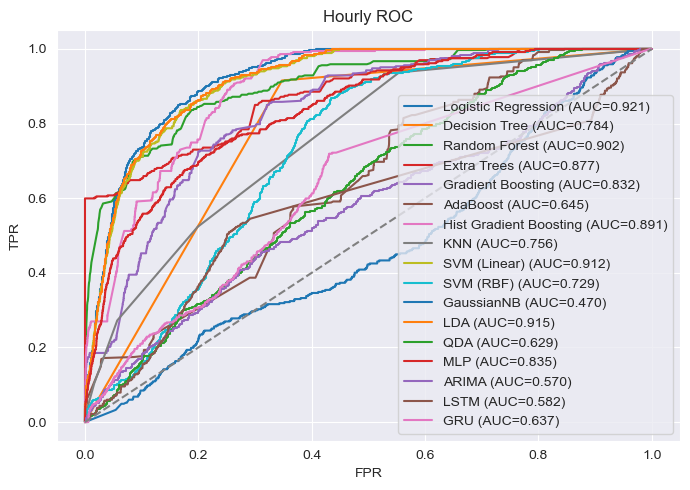

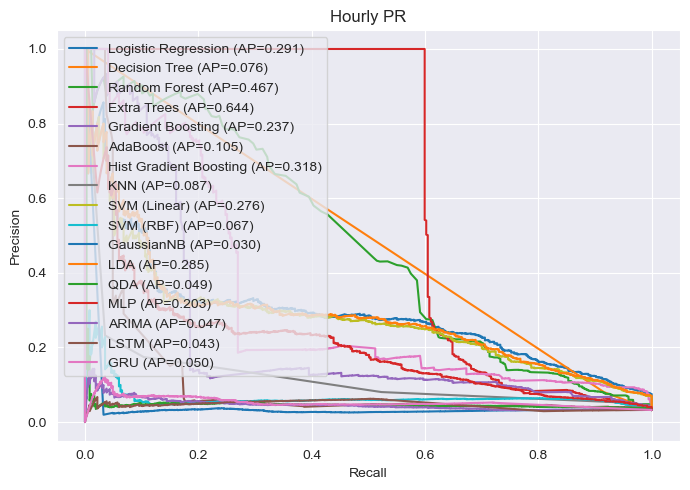

In [99]:
if ENABLE_HOURLY_PIPELINE and fitted_models_hr:
    from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

    y_all_hr = y_test_hr
    has_both = len(np.unique(y_all_hr)) > 1

    plt.figure(figsize=(7, 5))
    if not has_both:
        plt.text(0.5, 0.5, "ROC undefined (single class).", ha='center', va='center')
    else:
        for name, m in fitted_models_hr.items():
            s = prob_test_hr.get(name, None)
            if s is None:
                s = _prob_hr(m, X_test_hr)
            fpr, tpr, _ = roc_curve(y_all_hr, s)
            plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr, tpr):.3f})")
        plt.plot([0, 1], [0, 1], '--', color='grey')
    plt.xlabel("FPR");
    plt.ylabel("TPR");
    plt.title("Hourly ROC")
    plt.legend();
    plt.tight_layout();
    plt.show()

    plt.figure(figsize=(7, 5))
    if y_all_hr.sum() == 0:
        plt.text(0.5, 0.5, "PR undefined (no positives).", ha='center', va='center')
    else:
        for name, m in fitted_models_hr.items():
            s = prob_test_hr.get(name, None)
            if s is None:
                s = _prob_hr(m, X_test_hr)
            pr, rc, _ = precision_recall_curve(y_all_hr, s)
            ap = average_precision_score(y_all_hr, s)
            plt.plot(rc, pr, label=f"{name} (AP={ap:.3f})")
    plt.xlabel("Recall");
    plt.ylabel("Precision");
    plt.title("Hourly PR")
    plt.legend();
    plt.tight_layout();
    plt.show()

In [100]:
if ENABLE_HOURLY_PIPELINE and fitted_models_hr:
    def monthly_precision_recall_at_k_hours(df, scores, k=4):
        df = df.copy()
        df['score'] = scores
        total_hits = 0
        total_true = 0
        months = 0
        for (y, m), sub in df.groupby(['year', 'month']):
            if not (6 <= m <= 9):
                continue
            if len(sub) < 24 * 5:
                continue
            topk = sub.nlargest(k, 'score')
            hits = int(topk['is_CP'].sum())
            denom = int(sub['is_CP'].sum())
            total_hits += hits
            total_true += denom
            months += 1
        p_at_k = (total_hits / (k * months)) if months > 0 else np.nan
        r_at_k = (total_hits / total_true) if total_true > 0 else np.nan
        return p_at_k, r_at_k


    rows = []
    test_hr_eval = test_hr.copy()
    for name, s in prob_test_hr.items():
        p4, r4 = monthly_precision_recall_at_k_hours(test_hr_eval, s, k=4)
        rows.append({'Model': name, 'precision_at_4h': p4, 'recall_at_4h': r4})
    p4h_df = pd.DataFrame(rows).round(4).sort_values('precision_at_4h', ascending=False)
    print("Hourly Precision@4h / Recall@4h (Jun–Sep months):")
    display(p4h_df)

Hourly Precision@4h / Recall@4h (Jun–Sep months):


,Model,precision_at_4h,recall_at_4h
3,Extra Trees,1.0000,0.0436
2,Random Forest,0.8750,0.0381
4,Gradient Boosting,0.7500,0.0327
6,Hist Gradient Boosting,0.7500,0.0327
14,ARIMA,0.3750,0.0163
7,KNN,0.3125,0.0136
0,Logistic Regression,0.2500,0.0109
5,AdaBoost,0.2500,0.0109
1,Decision Tree,0.2500,0.0109
8,SVM (Linear),0.2500,0.0109


In [101]:
# python
from copy import deepcopy
from sklearn.metrics import average_precision_score, precision_recall_curve
import itertools

# 1. 准备数据划分：2022 训练拟合，2023 验证调参，2024+ 测试
train_core = model_df[model_df['year'] == 2022].copy()
val_core = model_df[model_df['year'] == 2023].copy()
test_core = model_df[model_df['year'] >= 2024].copy()

X_train_core = train_core[feature_cols]
y_train_core = train_core['is_CP'].astype(int).values
X_val_core = val_core[feature_cols]
y_val_core = val_core['is_CP'].astype(int).values


def precision_recall_at4_monthly(df, scores):
    df = df.copy()
    df['score'] = scores
    total_hits = total_true = months = 0
    for (y, m), sub in df.groupby(['year', 'month']):
        if not (6 <= m <= 9):
            continue
        if len(sub) < 20:
            continue
        top4 = sub.nlargest(4, 'score')
        hits = int(top4['is_CP'].sum())
        denom = int(sub['is_CP'].sum())
        total_hits += hits
        total_true += denom
        months += 1
    p4 = (total_hits / (4 * months)) if months > 0 else 0.0
    r4 = (total_hits / total_true) if total_true > 0 else 0.0
    return p4, r4


def fit_and_score(params, top_pct):
    # 2. 可选 Top% 重新构建训练集
    if top_pct is not None:
        thr = model_df['actual_peak'].quantile(1 - top_pct)
        top_idx = model_df.index[model_df['actual_peak'] >= thr]
        top_train = model_df.loc[top_idx]
        top_train = top_train[top_train['year'] == 2022]  # 仅2022防止信息泄漏
        X_tr = top_train[feature_cols];
        y_tr = top_train['is_CP'].astype(int).values
    else:
        X_tr, y_tr = X_train_core, y_train_core

    from sklearn.ensemble import ExtraTreesClassifier
    clf = ExtraTreesClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_leaf=params['min_samples_leaf'],
        class_weight=params['class_weight'],
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    clf.fit(X_tr, y_tr)
    val_scores = clf.predict_proba(X_val_core)[:, 1]
    # 3. 阈值选择：PR 曲线最大 F1
    prec, rec, ths = precision_recall_curve(y_val_core, val_scores)
    if len(ths) == 0:
        thr = 0.5
    else:
        f1 = (2 * prec * rec) / (prec + rec + 1e-12)
        idx = int(np.nanargmax(f1))
        thr = ths[idx - 1] if idx > 0 else ths[0]
    # 4. 计算月度 Precision@4 / Recall@4
    p4, r4 = precision_recall_at4_monthly(val_core, val_scores)
    ap = average_precision_score(y_val_core, val_scores) if y_val_core.sum() > 0 else 0.0
    return dict(
        top_pct=top_pct,
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_leaf=params['min_samples_leaf'],
        class_weight=str(params['class_weight']),
        thr=thr,
        precision_at4=round(p4, 4),
        recall_at4=round(r4, 4),
        AP=round(ap, 4),
        val_pos_rate=round(float(y_val_core.mean()), 4)
    )


param_grid = {
    'n_estimators': [400, 800],
    'max_depth': [None, 16],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}
top_pct_grid = [None, 0.08, 0.10, 0.12]

search_rows = []
for comb in itertools.product(param_grid['n_estimators'],
                              param_grid['max_depth'],
                              param_grid['min_samples_leaf'],
                              param_grid['class_weight']):
    p = dict(n_estimators=comb[0], max_depth=comb[1],
             min_samples_leaf=comb[2], class_weight=comb[3])
    for tp in top_pct_grid:
        try:
            r = fit_and_score(p, tp)
            search_rows.append(r)
        except Exception as e:
            search_rows.append(dict(top_pct=tp, error=str(e), **p))

search_df = pd.DataFrame(search_rows)
search_df = search_df.sort_values(['precision_at4', 'recall_at4', 'AP'], ascending=[False, False, False])
print("Extra Trees 参数搜索（验证年 2023）前 10 条：")
display(search_df.head(10))

best_row = search_df.iloc[0]
print("推荐参数:", best_row.to_dict())

Extra Trees 参数搜索（验证年 2023）前 10 条：


,top_pct,n_estimators,max_depth,min_leaf,class_weight,thr,precision_at4,recall_at4,AP,val_pos_rate
0,NaN,400,NaN,1,None,0.122500,0.25,0.25,0.1114,0.0438
48,NaN,800,16.0,1,None,0.132500,0.25,0.25,0.1094,0.0438
32,NaN,800,NaN,1,None,0.118750,0.25,0.25,0.1091,0.0438
4,NaN,400,NaN,1,balanced,0.120000,0.25,0.25,0.1079,0.0438
16,NaN,400,16.0,1,None,0.117500,0.25,0.25,0.1071,0.0438
36,NaN,800,NaN,1,balanced,0.111250,0.25,0.25,0.1041,0.0438
8,NaN,400,NaN,2,None,0.127935,0.25,0.25,0.0991,0.0438
56,NaN,800,16.0,2,None,0.080195,0.25,0.25,0.0982,0.0438
24,NaN,400,16.0,2,None,0.123651,0.25,0.25,0.0979,0.0438
40,NaN,800,NaN,2,None,0.079523,0.25,0.25,0.0962,0.0438


推荐参数: {'top_pct': nan, 'n_estimators': 400, 'max_depth': nan, 'min_leaf': 1, 'class_weight': 'None', 'thr': 0.1225, 'precision_at4': 0.25, 'recall_at4': 0.25, 'AP': 0.1114, 'val_pos_rate': 0.0438}


In [102]:
# python
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    average_precision_score, precision_recall_curve,
    precision_score, recall_score, f1_score
)

# 1. 保障前置数据
assert 'hourly_df' in globals(), "hourly_df 未构建"
assert {'datetime', 'actual_load', 'year', 'month'}.issubset(hourly_df.columns)
hourly_base = hourly_df.copy()

# 2. 超参数网格
K_grid = [1, 2, 3, 4, 5, 6, 7, 8, 12, 16, 20, 24, 32]
USE_TOP_PCT_TRAIN_HR = False
TOP_PCT_HR = 0.10  # 若启用上尾筛选
models_hour = {
    'ExtraTrees': ExtraTreesClassifier(
        n_estimators=600, max_depth=None,
        min_samples_leaf=2, n_jobs=-1,
        class_weight='balanced', random_state=42
    ),
    'HistGB': HistGradientBoostingClassifier(
        learning_rate=0.05, max_depth=8,
        max_iter=400, random_state=42
    ),
}

# 3. 特征列（可替换为 ALL）
forecast_files = range(1, 7)
feature_cols_hr = [f'ECA_load_{n}d' for n in forecast_files if f'ECA_load_{n}d' in hourly_base.columns]
assert feature_cols_hr, "未找到小时级特征列"

# 4. 划分
sep_year = 2024
train_mask = hourly_base['year'] < sep_year
test_mask = hourly_base['year'] >= sep_year
train_full = hourly_base.loc[train_mask].copy()
test_full = hourly_base.loc[test_mask].copy()


def build_peak_label(df, K):
    df = df.copy()
    df['is_peak_hour'] = 0
    summer = df['month'].between(6, 9)
    for (y, m), sub in df[summer].groupby(['year', 'month']):
        # 跳过残缺月份
        if len(sub) < 24 * 5:
            continue
        top_idx = sub.nlargest(K, 'actual_load').index
        df.loc[top_idx, 'is_peak_hour'] = 1
    return df


def seq_impute(df, cols):
    med = df[cols].median()
    return (df[cols].ffill().bfill().fillna(med))


def true_top4_hits(df, scores):
    """返回：命中数, Hit@4 (=precision@4h=recall@4h), 月数"""
    df = df.copy()
    df['score'] = scores
    hits_total = 0
    months = 0
    for (y, m), sub in df.groupby(['year', 'month']):
        if not (6 <= m <= 9):
            continue
        if len(sub) < 24 * 5:
            continue
        # 真实前4小时
        true_top = set(sub.nlargest(4, 'actual_load').index)
        pred_top = set(sub.nlargest(4, 'score').index)
        hits = len(true_top & pred_top)
        hits_total += hits
        months += 1
    if months == 0:
        return 0, np.nan, 0
    hit_at_4 = hits_total / (4 * months)
    return hits_total, hit_at_4, months


def choose_f1_threshold(y_true, prob):
    if y_true.sum() == 0:
        return 0.5
    p, r, th = precision_recall_curve(y_true, prob)
    f1 = (2 * p * r) / (p + r + 1e-12)
    i = np.nanargmax(f1)
    if i == 0:
        return th[0]
    return th[i - 1]


rows = []
for K in K_grid:
    # 5. 生成标签
    trainK = build_peak_label(train_full, K)
    testK = build_peak_label(test_full, K)

    # 可选：上尾筛选训练
    if USE_TOP_PCT_TRAIN_HR:
        thr = trainK['actual_load'].quantile(1 - TOP_PCT_HR)
        train_sel = trainK[trainK['actual_load'] >= thr].copy()
    else:
        train_sel = trainK

    X_train = seq_impute(train_sel, feature_cols_hr)
    y_train_peak = train_sel['is_peak_hour'].values
    y_train_cp = train_sel['is_CP'].values if 'is_CP' in train_sel.columns else np.zeros(len(train_sel))

    X_test = seq_impute(testK, feature_cols_hr)
    y_test_peak = testK['is_peak_hour'].values
    y_test_cp = testK['is_CP'].values if 'is_CP' in testK.columns else np.zeros(len(testK))

    for mname, m in models_hour.items():
        try:
            m.fit(X_train, y_train_peak)
            prob_test = m.predict_proba(X_test)[:, 1] if hasattr(m, 'predict_proba') else m.decision_function(X_test)
            # 排序任务主指标：真实负荷 Top4 命中
            hits, hit_at4, months = true_top4_hits(testK, prob_test)
            # 分类视角（针对 is_peak_hour）
            thr = choose_f1_threshold(y_train_peak,
                                      m.predict_proba(X_train)[:, 1] if hasattr(m, 'predict_proba') else prob_test[
                                          :len(X_train)])
            y_pred_peak = (prob_test >= thr).astype(int)
            peak_prec = precision_score(y_test_peak, y_pred_peak, zero_division=0)
            peak_rec = recall_score(y_test_peak, y_pred_peak, zero_division=0)
            peak_f1 = f1_score(y_test_peak, y_pred_peak, zero_division=0)
            ap_peak = average_precision_score(y_test_peak, prob_test) if y_test_peak.sum() else np.nan
            # 与 is_CP 标签对比（可选）
            if y_test_cp.sum() > 0:
                # 复用同一概率，仅观察对粗标签的区分
                ap_cp = average_precision_score(y_test_cp, prob_test)
                # 粗标签的 P/R 在统一阈值下
                y_pred_cp = (prob_test >= np.quantile(prob_test,
                                                      1 - y_train_cp.mean() if y_train_cp.mean() > 0 else 0.5)).astype(
                    int)
                cp_prec = precision_score(y_test_cp, y_pred_cp, zero_division=0)
                cp_rec = recall_score(y_test_cp, y_pred_cp, zero_division=0)
            else:
                ap_cp = np.nan;
                cp_prec = np.nan;
                cp_rec = np.nan
            rows.append(dict(
                K=K, model=mname,
                pos_rate_train=round(y_train_peak.mean(), 4),
                pos_rate_test=round(y_test_peak.mean(), 4),
                months=months,
                hits_total=hits,
                Hit_at_4=hit_at4,
                AP_peak=ap_peak,
                Peak_P=peak_prec, Peak_R=peak_rec, Peak_F1=peak_f1,
                AP_CP=ap_cp, CP_P=cp_prec, CP_R=cp_rec
            ))
        except Exception as e:
            rows.append(dict(K=K, model=mname, error=str(e)))

res_df = pd.DataFrame(rows)
if not res_df.empty:
    res_df = res_df.sort_values(['Hit_at_4', 'AP_peak', 'Peak_F1'], ascending=[False, False, False])
    display(res_df)
else:
    print("无结果，请检查前置数据。")

print("推荐优先按 Hit_at_4 选 K；若多组并列，再看 AP_peak 与 Peak_F1。")

,K,model,pos_rate_train,pos_rate_test,months,hits_total,Hit_at_4,AP_peak,Peak_P,Peak_R,Peak_F1,AP_CP,CP_P,CP_R
0,1,ExtraTrees,0.0005,0.0004,4,3,0.1875,0.126153,0.000000,0.000000,0.000000,0.064932,0.093812,0.128065
14,8,ExtraTrees,0.0038,0.0028,4,3,0.1875,0.045673,0.000000,0.000000,0.000000,0.076369,0.129741,0.177112
1,1,HistGB,0.0005,0.0004,4,3,0.1875,0.003495,0.009804,0.250000,0.018868,0.049369,0.015751,0.122616
24,32,ExtraTrees,0.0153,0.0112,4,2,0.1250,0.104998,0.000000,0.000000,0.000000,0.083758,0.109780,0.149864
12,7,ExtraTrees,0.0033,0.0025,4,2,0.1250,0.026791,0.000000,0.000000,0.000000,0.079909,0.131737,0.179837
2,2,ExtraTrees,0.0010,0.0007,4,2,0.1250,0.020791,0.000000,0.000000,0.000000,0.066423,0.093812,0.128065
8,5,ExtraTrees,0.0024,0.0018,4,2,0.1250,0.019088,0.000000,0.000000,0.000000,0.069134,0.095808,0.130790
10,6,ExtraTrees,0.0029,0.0021,4,2,0.1250,0.016909,0.000000,0.000000,0.000000,0.079650,0.119760,0.163488
25,32,HistGB,0.0153,0.0112,4,1,0.0625,0.086197,0.164384,0.187500,0.175182,0.090103,0.141717,0.193460
23,24,HistGB,0.0115,0.0084,4,1,0.0625,0.061609,0.099448,0.187500,0.129964,0.075849,0.121756,0.166213


推荐优先按 Hit_at_4 选 K；若多组并列，再看 AP_peak 与 Peak_F1。


In [103]:
# python
# ==== 单小时级模型详细表现查看 ====
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve

# -------- 可配置参数 --------
selected_hourly_model = "Extra Trees"      # 需在 fitted_models_hr 中
TARGET_LABEL_HR = "is_peak_hour"           # 可选: 'is_peak_hour' 或 'is_CP'
MONTH_RANGE = (6, 9)                       # (start_month, end_month)
YEARS_FILTER = None                        # 例如 [2024]；None=全部测试年
TOP_K_HOURS = 4                            # Top-K 小时
SHOW_TOPK_ROWS = True                      # 是否展示每月 Top-K 具体行
RANK_BY_SCORE_FOR_TOPK = True              # True 用连续得分排序；False 用二分类预测再按得分
USE_ADAPTIVE_THRESHOLD_HR_VIEW = True      # 使用 thr_hr_by_model 的阈值
FALLBACK_FIXED_THR = 0.5                   # 无自适应时固定阈值
PRINT_EMPTY_MONTH = False                  # 无数据月份是否提示
# --------------------------------

# 依赖检查
required_vars = ['fitted_models_hr', 'test_hr', 'feature_cols_hr']
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise RuntimeError(f"缺少变量: {missing}")
if TARGET_LABEL_HR not in test_hr.columns:
    raise RuntimeError(f"测试集缺少目标列: {TARGET_LABEL_HR}")

if selected_hourly_model not in fitted_models_hr:
    print(f"[WARN] 模型 {selected_hourly_model} 不在 fitted_models_hr 中。")
else:
    mdl = fitted_models_hr[selected_hourly_model]

    # 阈值获取
    if USE_ADAPTIVE_THRESHOLD_HR_VIEW and 'thr_hr_by_model' in globals():
        adaptive_thr = thr_hr_by_model.get(selected_hourly_model, FALLBACK_FIXED_THR)
    else:
        adaptive_thr = FALLBACK_FIXED_THR

    # 取测试期并过滤月份 / 年份
    m0, m1 = MONTH_RANGE
    period_mask = (test_hr['month'] >= m0) & (test_hr['month'] <= m1)
    period_data = test_hr.loc[period_mask].copy()
    if YEARS_FILTER is not None:
        period_data = period_data[period_data['year'].isin(YEARS_FILTER)].copy()

    if period_data.empty:
        print("[INFO] 选定时间范围无测试数据。")
    else:
        EPS = 1e-12

        def _scores(model, X):
            if hasattr(model, "predict_proba"):
                s = model.predict_proba(X)[:, 1]
            else:
                raw = model.decision_function(X)
                raw = (raw - raw.min()) / (raw.max() - raw.min() + EPS)
                s = raw
            s = np.asarray(s, dtype=float)
            s = np.nan_to_num(s, nan=0.5, posinf=1.0, neginf=0.0)
            return np.clip(s, 0, 1)

        scores = _scores(mdl, period_data[feature_cols_hr])
        sc_col = f"{selected_hourly_model}_score"
        period_data[sc_col] = scores

        # 生成二分类列
        period_data[f"{selected_hourly_model}_pred"] = (scores >= adaptive_thr).astype(int)

        summary_rows = []
        month_keys = (period_data[['year', 'month']]
                      .drop_duplicates()
                      .sort_values(['year', 'month'])
                      .itertuples(index=False, name=None))

        for (yy, mm) in month_keys:
            sub = period_data[(period_data['year'] == yy) & (period_data['month'] == mm)].copy()
            if len(sub) < 24 * 5:  # 跳过严重残缺月
                if PRINT_EMPTY_MONTH:
                    print(f"[SKIP] {yy}-{mm:02d} 数据不足: {len(sub)}")
                continue

            # 排序字段
            rank_col = sc_col if RANK_BY_SCORE_FOR_TOPK else f"{selected_hourly_model}_pred"
            sub = sub.sort_values(rank_col, ascending=False)

            # Top-K
            topk = sub.head(TOP_K_HOURS).copy()
            target_vec = sub[TARGET_LABEL_HR].astype(int)
            top_hits = int(topk[TARGET_LABEL_HR].sum())
            total_pos = int(target_vec.sum())

            precision_k = top_hits / TOP_K_HOURS if TOP_K_HOURS > 0 else np.nan
            recall_k = top_hits / total_pos if total_pos > 0 else np.nan

            # PR / AP （针对连续得分）
            if total_pos > 0 and target_vec.nunique() > 1:
                try:
                    ap = average_precision_score(sub[TARGET_LABEL_HR], sub[sc_col])
                except Exception:
                    ap = np.nan
            else:
                ap = np.nan

            # 阈值分类 F1
            tp = ((sub[TARGET_LABEL_HR] == 1) & (sub[f"{selected_hourly_model}_pred"] == 1)).sum()
            fp = ((sub[TARGET_LABEL_HR] == 0) & (sub[f"{selected_hourly_model}_pred"] == 1)).sum()
            fn = ((sub[TARGET_LABEL_HR] == 1) & (sub[f"{selected_hourly_model}_pred"] == 0)).sum()
            prec_thr = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            rec_thr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1_thr = 2 * prec_thr * rec_thr / (prec_thr + rec_thr + EPS) if (prec_thr + rec_thr) > 0 else 0.0

            summary_rows.append(dict(
                year=yy, month=mm, samples=len(sub),
                positives=total_pos,
                TopK=TOP_K_HOURS,
                hits=top_hits,
                Precision_at_K=precision_k,
                Recall_at_K=recall_k,
                AP=ap,
                thr=adaptive_thr,
                Thr_Prec=prec_thr,
                Thr_Rec=rec_thr,
                Thr_F1=f1_thr
            ))

            if SHOW_TOPK_ROWS:
                print(f"\n=== {yy}-{mm:02d} Top-{TOP_K_HOURS} — {selected_hourly_model} ({TARGET_LABEL_HR}) ===")
                display(topk[['datetime', 'actual_load', TARGET_LABEL_HR, sc_col]]
                        .reset_index(drop=True))
                print(f"Hits={top_hits}/{TOP_K_HOURS}  TruePos={total_pos}  "
                      f"P@{TOP_K_HOURS}={precision_k:.2%}  R@{TOP_K_HOURS}={(recall_k if total_pos>0 else 0):.2%}  "
                      f"Thr={adaptive_thr:.4f}  ThrF1={f1_thr:.3f}")

        if summary_rows:
            summary_df = (pd.DataFrame(summary_rows)
                          .sort_values(['year', 'month'])
                          .reset_index(drop=True))
            num_cols = ['Precision_at_K', 'Recall_at_K', 'AP', 'Thr_Prec', 'Thr_Rec', 'Thr_F1']
            for c in num_cols:
                if c in summary_df.columns:
                    summary_df[c] = summary_df[c].astype(float)
            print(f"\n=== 汇总: {selected_hourly_model} 小时级 Top-{TOP_K_HOURS} ({TARGET_LABEL_HR}) ===")
            display(summary_df)

            # 总体加权（按月平均）
            agg_row = dict(
                model=selected_hourly_model,
                label=TARGET_LABEL_HR,
                months=len(summary_df),
                mean_P_at_K=summary_df['Precision_at_K'].mean(),
                mean_R_at_K=summary_df['Recall_at_K'].mean(),
                mean_AP=summary_df['AP'].mean(),
                mean_Thr_F1=summary_df['Thr_F1'].mean()
            )
            print("总体月均：", {k: (round(v,4) if isinstance(v,(int,float)) else v) for k,v in agg_row.items()})
        else:
            print("[INFO] 范围内无可汇总月份。")

RuntimeError: 测试集缺少目标列: is_peak_hour